# Industries Project

Author: Mateo Marks

The development of new technologies is challenging traditional statistical models used in the financial industry. For this exercise, we will attempt to forecast the yearly returns of Industries' portfolios utilizing machine learning models.

Based on a review of multiple machine learning models, we will decide which is the best model to estimate the different industries' portfolio performance.

## Import required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Graph Formatting

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize = (10,6))         # size fo the graph

## Import Economic Indicators

In [3]:
economic_data = pd.DataFrame()

In [4]:
excel_file = "US_Inflation.xlsx"

CPI_raw = pd.read_excel(excel_file, header=0,index_col=0, sheet_name='Data', engine='openpyxl')/100
CPI_raw.index = pd.to_datetime(CPI_raw.index, format="%Y-%m-%d").to_period('Y')
economic_data['inflation'] = CPI_raw

In [5]:
excel_file = "US_GDP.xlsx"

GDP_raw = pd.read_excel(excel_file, header=0,index_col=0, sheet_name='Data', engine='openpyxl')
GDP_raw.index = pd.to_datetime(GDP_raw.index, format="%Y-%m-%d").to_period('Y')
GDP_raw = np.log(GDP_raw/GDP_raw.shift(1)).dropna()
economic_data['growth'] = GDP_raw

In [6]:
economic_data.head()

,inflation,growth
Year,,
1960,0.014580,0.008788
1961,0.010707,0.061993
1962,0.011988,0.042169
1963,0.012397,0.050296
1964,0.012789,0.050278


In [7]:
economic_data.describe()

,inflation,growth
count,62.000000,62.000000
mean,0.036965,0.029372
std,0.027536,0.022389
min,-0.003555,-0.025732
25%,0.018337,0.018859
50%,0.029834,0.027286
75%,0.042986,0.043678
max,0.135492,0.081231


In [8]:
def dN(x,mu,sigma):
    '''Probability density function of a normal
    random variable
    '''
    z = (x - mu) / sigma
    pdf=np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
    return pdf

In [9]:
def return_histogram(name,rets):
    '''Plot a Histogram
    '''
    plt.figure(figsize=(10,6))
    x = np.linspace(min(rets), max(rets), 100)
    plt.hist(np.array(rets), bins=50, density=True)
    y = dN(x, np.mean(rets), np.std(rets))
    plt.plot(x, y, linewidth = 2)
    plt.xlabel('change')
    plt.ylabel('frequency/probability')
    plt.grid(True)
    title = name + " histogram of growth"
    plt.title(title)

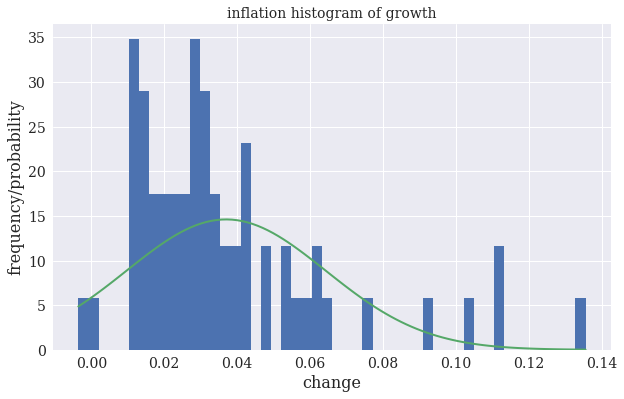

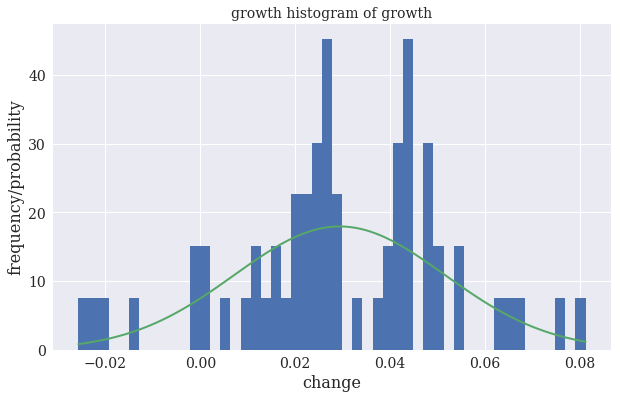

In [10]:
for sym in economic_data.columns:
    return_histogram(sym, economic_data[sym].values)

In [11]:
med_inflation = np.median(economic_data['inflation'], axis=0)
med_inflation

0.029833661716349647

In [12]:
med_growth = np.median(economic_data['growth'], axis=0)
med_growth

0.027285580121212134

In [13]:
def categorize(year):
    if (year['inflation'] < med_inflation) and (year['growth'] < med_growth):
        val = 'Reflation'
    elif (year['inflation'] < med_inflation) and (year['growth'] >= med_growth):
        val = 'Recovery'
    elif (year['inflation'] >= med_inflation) and (year['growth'] < med_growth):
        val = 'Stagflation'
    elif (year['inflation'] >= med_inflation) and (year['growth'] >= med_growth):
        val = 'Overheat'
    return val

In [14]:
economic_data['regimes'] = economic_data.apply(categorize, axis=1)

In [15]:
economic_data['regimes'].value_counts()

Reflation      17
Overheat       17
Recovery       14
Stagflation    14
Name: regimes, dtype: int64

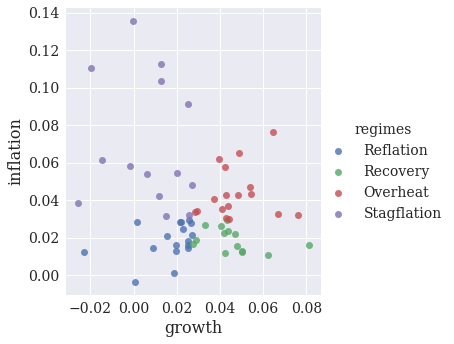

In [16]:
sns.lmplot(
    data=economic_data,
    y="inflation", x="growth", fit_reg=False, hue='regimes');

In [17]:
regimes = economic_data['regimes']

## Import Industry Metrics

Categories construction: Assigns each NYSE, AMEX, and NASDAQ stock to an industry portfolio at the end of June of year t based on its four-digit SIC code at that time. (Uses Compustat SIC codes for the fiscal year ending in calendar year t-1. Whenever Compustat SIC codes are not available, uses CRSP SIC codes for June of year t.) Then computes returns from July of t to June of t+1
 
 1. NoDur  Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
 2. Durbl  Consumer Durables -- Cars, TVs, Furniture, Household Appliances
 3. Manuf  Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
 4. Enrgy  Oil, Gas, and Coal Extraction and Products
 5. HiTec  Business Equipment -- Computers, Software, and Electronic Equipment
 6. Telcm  Telephone and Television Transmission
 7. Shops  Wholesale, Retail, and Some Services (Laundries, Repair Shops)
 8. Hlth   Healthcare, Medical Equipment, and Drugs
 9. Utils  Utilities
 10. Other -- Other Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance

Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html

In [18]:
excel_file = "Industry_Portfolios.xlsx"

ind_raw = pd.read_excel(excel_file, header=0,index_col=0, na_values=-99.99,sheet_name='Data', engine='openpyxl')/100
ind_raw.index = pd.to_datetime(ind_raw.index, format="%Y").to_period('Y')
ind_raw = ind_raw.loc['1960':]

In [19]:
ind_raw.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Year,,,,,,,,,,
1960,0.2771,-0.2304,-0.1155,-0.0188,0.0180,0.3209,0.0561,0.0570,0.2091,0.0031
1961,0.3572,0.5079,0.1763,0.2644,0.2217,0.3033,0.4600,0.2669,0.2807,0.2953
1962,-0.2264,0.0105,-0.1385,0.0956,-0.2033,-0.1247,-0.1847,-0.2018,-0.0013,-0.0717
1963,0.1605,0.3636,0.2019,0.2278,0.2639,0.2161,0.1923,0.2067,0.1135,0.2269
1964,0.1302,0.2191,0.1466,0.2666,0.0301,0.0246,0.3167,0.1651,0.1618,0.1395


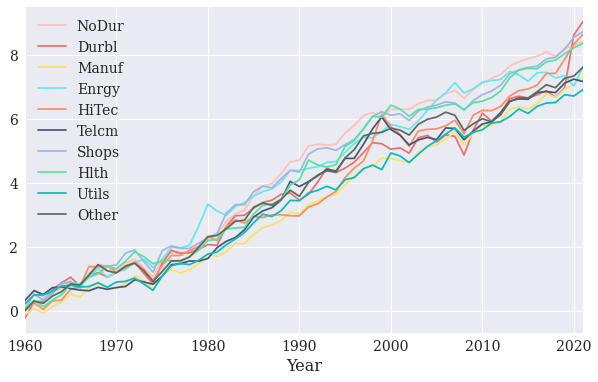

In [55]:
ind_raw.cumsum().plot();

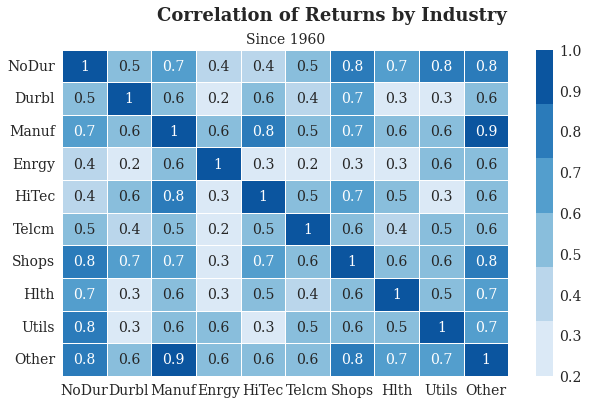

In [58]:
fig, ax = plt.subplots()
fig.suptitle('Correlation of Returns by Industry',fontweight="bold")
ax.set_title("Since 1960")
sns.heatmap(ind_raw.corr().round(1),
            cmap=sns.color_palette('Blues'), annot=True, linewidths=.5, ax=ax);

## Calculate returns by category

In [20]:
data = pd.concat((regimes, ind_raw), axis=1)
data.head()

,regimes,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Year,,,,,,,,,,,
1960,Reflation,0.2771,-0.2304,-0.1155,-0.0188,0.0180,0.3209,0.0561,0.0570,0.2091,0.0031
1961,Recovery,0.3572,0.5079,0.1763,0.2644,0.2217,0.3033,0.4600,0.2669,0.2807,0.2953
1962,Recovery,-0.2264,0.0105,-0.1385,0.0956,-0.2033,-0.1247,-0.1847,-0.2018,-0.0013,-0.0717
1963,Recovery,0.1605,0.3636,0.2019,0.2278,0.2639,0.2161,0.1923,0.2067,0.1135,0.2269
1964,Recovery,0.1302,0.2191,0.1466,0.2666,0.0301,0.0246,0.3167,0.1651,0.1618,0.1395


In [21]:
regs = economic_data['regimes'].unique()

In [22]:
by_reg = pd.DataFrame()
for i in regs:
    by_reg[i] = data.loc[data['regimes'] == i].drop(['regimes'], axis=1).median()

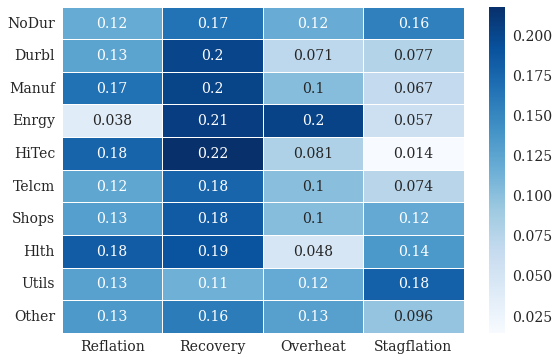

In [23]:
# Draw a heatmap with the numeric values in each cell

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(by_reg, annot=True, linewidths=.5, ax=ax, cmap="Blues");

In [24]:
by_reg.describe()

,Reflation,Recovery,Overheat,Stagflation
count,10.000000,10.000000,10.000000,10.000000
mean,0.132130,0.181350,0.107110,0.097515
std,0.040769,0.030155,0.041429,0.049880
min,0.037600,0.113750,0.047600,0.014250
25%,0.123750,0.168137,0.085825,0.068375
50%,0.128250,0.186950,0.101700,0.086675
75%,0.158100,0.201750,0.118875,0.131312
max,0.183100,0.217450,0.202500,0.179300


In [25]:
by_reg['color'] = ["#EF6F6C", "#465775", "#56E39F", "#08BDBD", "#5B6C5D", "#9EB7E5","#64E9EE", "#F8E16C", "#FFC2B4","#FB8F67"]

In [26]:
def plot_rets(ind):
    plot = pd.DataFrame(by_reg[[ind,'color']].sort_values(by=ind, ascending=False)).T
    fig, ax = plt.subplots()
    fig.suptitle('Regime: ' + str(ind),fontweight="bold")
    ax.set_title('Return by Industry')
    ax.set_xlabel('Industry')
    
    categ_color = plot.loc['color'].values
    
    sns.set_palette(categ_color)
    
    sns.barplot(data=pd.DataFrame(plot.loc[ind]).T);

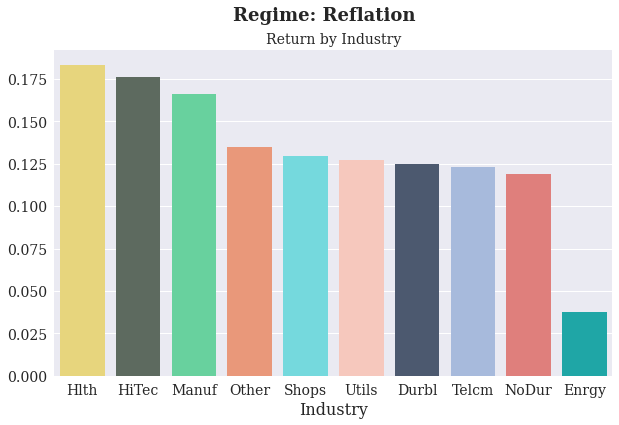

In [27]:
plot_rets('Reflation')

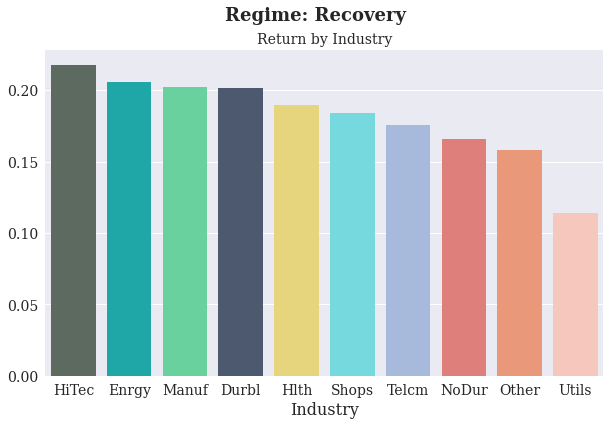

In [28]:
plot_rets('Recovery')

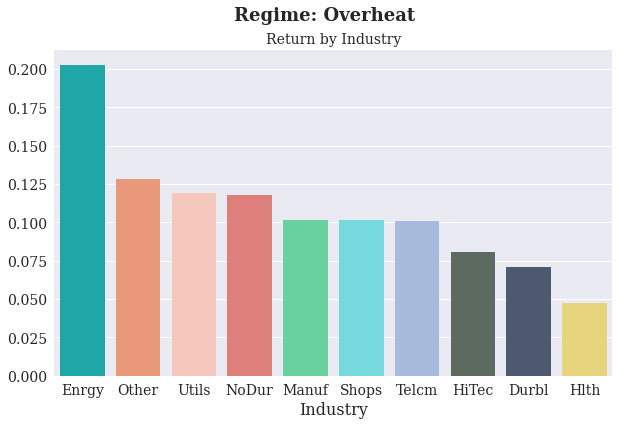

In [29]:
plot_rets('Overheat')

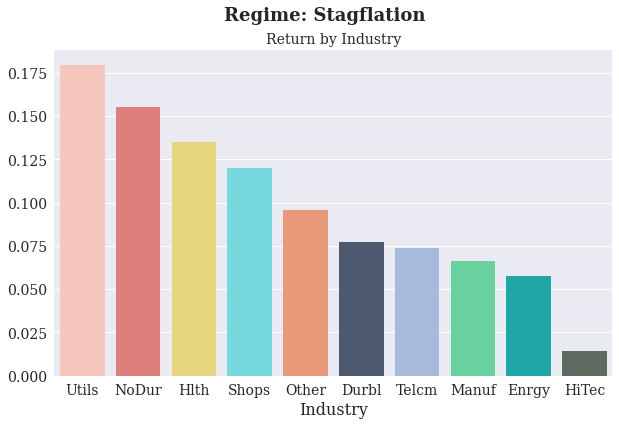

In [30]:
plot_rets('Stagflation')

## Simple Beta Calculation

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
ml_data = data.copy()

In [33]:
regimes_cat = ml_data[['regimes']]
regimes_cat.head()

,regimes
Year,
1960,Reflation
1961,Recovery
1962,Recovery
1963,Recovery
1964,Recovery


In [34]:
cat_encoder = OneHotEncoder(sparse=False)
dummy_regimes = cat_encoder.fit_transform(regimes_cat)

In [35]:
dummy_regimes[:10]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [36]:
from sklearn.linear_model import LinearRegression

In [38]:
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(dummy_regimes, ml_data['Hlth'])

LinearRegression(fit_intercept=False)

In [42]:
cat_encoder.categories_

[array(['Overheat', 'Recovery', 'Reflation', 'Stagflation'], dtype=object)]

In [39]:
lin_reg.coef_

array([0.09527647, 0.16325714, 0.135     , 0.15352857])

In [49]:
ml_col = cat_encoder.categories_
lr_coef= pd.DataFrame(index = ml_col)

In [50]:
for i in ind_raw.columns:
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(dummy_regimes, ml_data[i])
    lr_coef[i] = lin_reg.coef_

In [52]:
lr_coef.T

,Overheat,Recovery,Reflation,Stagflation
NoDur,0.122447,0.134657,0.138712,0.148571
Durbl,0.079071,0.225164,0.234571,0.039193
Manuf,0.094741,0.174943,0.141194,0.059429
Enrgy,0.184388,0.179814,0.044476,0.086243
HiTec,0.062988,0.246971,0.205476,0.043293
Telcm,0.085259,0.161693,0.118000,0.102750
Shops,0.084600,0.185114,0.146829,0.156686
Hlth,0.095276,0.163257,0.135000,0.153529
Utils,0.125624,0.117293,0.091071,0.112814
Other,0.134771,0.169029,0.130976,0.051164


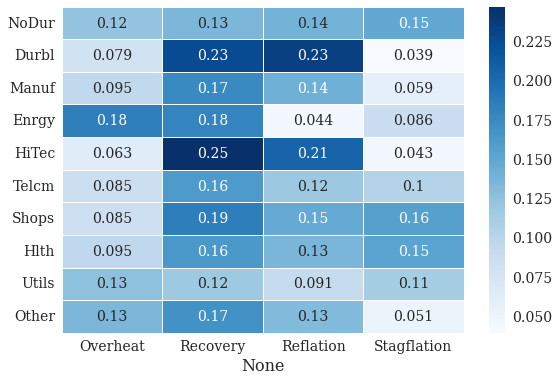

In [54]:
# Draw a heatmap with the numeric values in each cell

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(lr_coef.T, annot=True, linewidths=.5, ax=ax, cmap="Blues");